In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2
max_data_size = 100000
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
max_count = 300000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source_len < len(source):
        max_source_len = len(source)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Gene /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, max_source_len)
print(vgene_tag.shape, vgenes)


(288774,) 526
(288774,) 63


In [4]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
y_data = to_categorical(vgene_tag)

train_index = int((len(x_data) / batch_size) * 0.80 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (231019, 288773, 346527)
(231019, 526) (231019, 63)
(57754, 526) (57754, 63)
(1, 526) (1, 63)


# Deep Network with Dense Layer

In [19]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(max_source_len,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source_len, \
                      name='embedding')(input_source)

lstm_layer = LSTM(5, return_sequences=True)(embedding)
lstm_layer = Dropout(0.25)(lstm_layer)
reshape_layer = Reshape((max_source_len*5,))(embedding)

dense_layer_first = Dense(1024, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
embedding (Embedding)        (None, 526, 5)            30        
_________________________________________________________________
reshape_7 (Reshape)          (None, 2630)              0         
_________________________________________________________________
fstlayer (Dense)             (None, 1024)              2694144   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
midlayer (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
__________

In [20]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=50, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 231019 samples, validate on 57754 samples
Epoch 1/50
 - 25s - loss: 2.0254 - acc: 0.4511 - val_loss: 0.6164 - val_acc: 0.8021
Epoch 2/50
 - 24s - loss: 0.5166 - acc: 0.8322 - val_loss: 0.3048 - val_acc: 0.8864
Epoch 3/50
 - 24s - loss: 0.3000 - acc: 0.9020 - val_loss: 0.2218 - val_acc: 0.9109
Epoch 4/50
 - 25s - loss: 0.2254 - acc: 0.9256 - val_loss: 0.1901 - val_acc: 0.9239
Epoch 5/50
 - 25s - loss: 0.1795 - acc: 0.9402 - val_loss: 0.1629 - val_acc: 0.9361
Epoch 6/50
 - 24s - loss: 0.1471 - acc: 0.9507 - val_loss: 0.1504 - val_acc: 0.9461
Epoch 7/50
 - 25s - loss: 0.1335 - acc: 0.9552 - val_loss: 0.1386 - val_acc: 0.9509
Epoch 8/50
 - 25s - loss: 0.1127 - acc: 0.9618 - val_loss: 0.1371 - val_acc: 0.9528
Epoch 9/50
 - 25s - loss: 0.1049 - acc: 0.9645 - val_loss: 0.1289 - val_acc: 0.9569
Epoch 10/50
 - 25s - loss: 0.1033 - acc: 0.9665 - val_loss: 0.1262 - val_acc: 0.9580
Epoch 11/50
 - 24s - loss: 0.0895 - acc: 0.9701 - val_loss: 0.1405 - val_acc: 0.9550
Epoch 12/50
 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
51 51


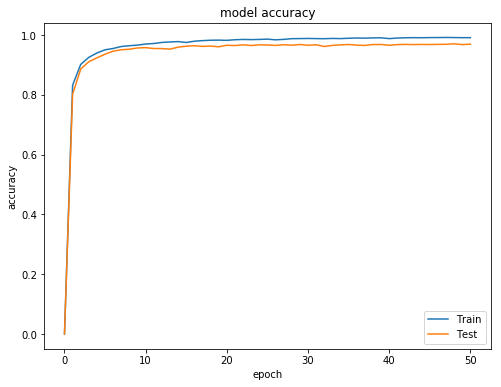

In [31]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['acc']
valid = history.history['val_acc']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
